# visualize_PairwiseAligner

This notebook is based on analysis.ipynb of gene_transformer, <br>
and is the prototype of visualize.py of biosynseq.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt # need to import matplotlib before pandas
import pandas as pd
from pathlib import Path
from mdlearn.utils import plot_scatter
from typing import Dict, List
from argparse import ArgumentParser, Namespace

from Bio import SeqIO, SeqUtils, SeqRecord
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint

import logging 
from cuml.manifold import TSNE
from cuml.manifold import UMAP

/homes/lind/.conda/envs/mdhpipeline/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams.update({'font.size':18})

# Generated embeddings

In [3]:
generated_embed_path = "/homes/mzvyagin/MDH/perlmutter_data/gpt2_generated_embeddings.npy"
generated_embed = np.load(generated_embed_path)

In [4]:
generated_embed.shape

(128, 512, 768)

In [5]:
# Average residue dimension to get a single embedding per sequence (axis=1 means columns)
# can have a function that just loads the data and returns the embed_avg
generated_avg = generated_embed.mean(axis=1)

In [6]:
generated_avg.shape

(128, 768)

In [7]:
generated_fasta_path = "/homes/mzvyagin/MDH/perlmutter_data/globalstep2850.fasta"

# list() allows for random access to the records in any order
generated_seqs = list(SeqIO.parse(generated_fasta_path, "fasta")) 

In [8]:
# translate the generated DNA sequence into a protein sequence
# to_stop=True: translation is terminated at the first in frame stop codon
generated_protein_seqs = [s.translate(to_stop=True) for s in generated_seqs]

In [9]:
generated_protein_seqs[0]

SeqRecord(seq=Seq('MKVTIVGAGAVGASCAEYIAIKNFASEVVLLDIKEGYAEGKAMDLMQCASLNGF...LEL'), id='<unknown id>', name='<unknown name>', description='<unknown description>', dbxrefs=[])

## Sequence metrics

In [10]:
# Sequence metrics (scalar value per sequence)
def gc_content(seqs):
    return [SeqUtils.GC(rec.seq) for rec in seqs]

def seq_length(seqs):
    return [len(rec.seq) for rec in seqs]

def molecular_weight(seqs):
    return [SeqUtils.molecular_weight(rec.seq, "protein") for rec in seqs]

def isoelectric_point(seqs):
    return [IsoelectricPoint(seq).pi() for seq in seqs]

In [11]:
generated_paint_df = pd.DataFrame({
        "GC": gc_content(generated_seqs),
        "SequenceLength": seq_length(generated_seqs),
        "MolecularWeight": molecular_weight(generated_protein_seqs),
        "IsoelectricPoint": isoelectric_point(generated_protein_seqs),
})

In [12]:
generated_paint_df.corr()

,GC,SequenceLength,MolecularWeight,IsoelectricPoint
GC,1.000000,0.754317,0.530526,0.385670
SequenceLength,0.754317,1.000000,0.859658,0.706478
MolecularWeight,0.530526,0.859658,1.000000,0.894860
IsoelectricPoint,0.385670,0.706478,0.894860,1.000000


In [13]:
print(type(generated_paint_df.corr()))

<class 'pandas.core.frame.DataFrame'>


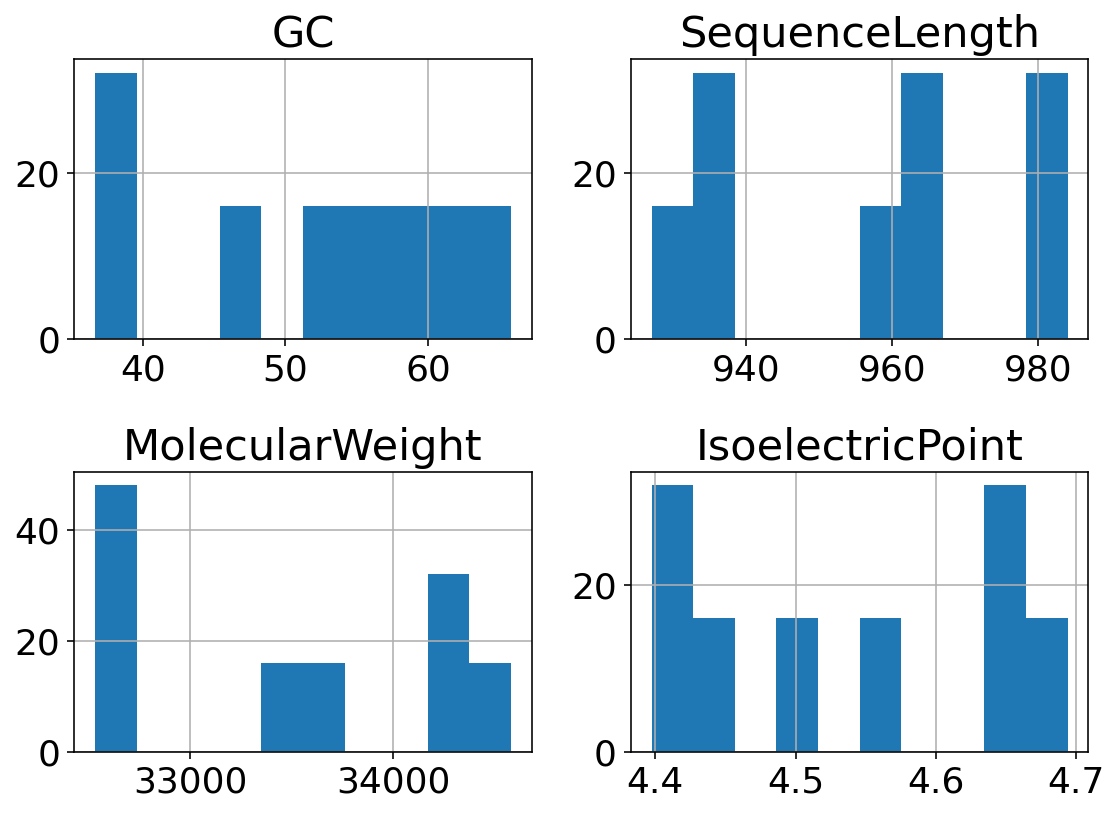

In [14]:
# histogram distribution of sequence metrics
generated_paint_df.hist()
plt.tight_layout()

In [15]:
# TO DO: 
# (1) Histogram distribution of paint_df
# (2) Histogram distribution of a particular sequence metrics, with test vs. val
# (3) plot_scatter plots
# (4) run_tsne, plot_tsne
# (5) run_umap, plot_umap
# (6) alignment score plots

## t-SNE

In [16]:
def run_tsne(data: np.ndarray):
    # rapidsai only supports 2 dimensions
    model = TSNE(n_components=2, method="barnes_hut")
    data_proj = model.fit_transform(data)
    return data_proj

In [17]:
def plot_tsne(data_proj: np.ndarray, paint: np.ndarray, paint_name: str, tsne_path: Path, cmap: str = "viridis"):
    df = pd.DataFrame({"z0": data_proj[:, 0], "z1": data_proj[:, 1], paint_name: paint[:data_proj.shape[0]]})
    ax = df.plot.scatter(x='z0', y='z1',c=paint_name, colormap=cmap, alpha=0.4)
    fig = ax.get_figure()
    fig.show()
    
    # save each tsne plot as a separate image in the specified directory
    if os.path.isdir(tsne_path):
        fig.savefig(tsne_path/(f"{paint_name}_tsne.png"), dpi=300)
    else: 
        raise ValueError(f"{tsne_path} is not a directory!")
    return df

In [18]:
tsne_path = Path("/homes/lind/MDH-pipeline/visualize/")
print(tsne_path)
print(type(tsne_path))
print(type(str(tsne_path)))
print(str(tsne_path))

/homes/lind/MDH-pipeline/visualize
<class 'pathlib.PosixPath'>
<class 'str'>
/homes/lind/MDH-pipeline/visualize


GC
SequenceLength
MolecularWeight
IsoelectricPoint


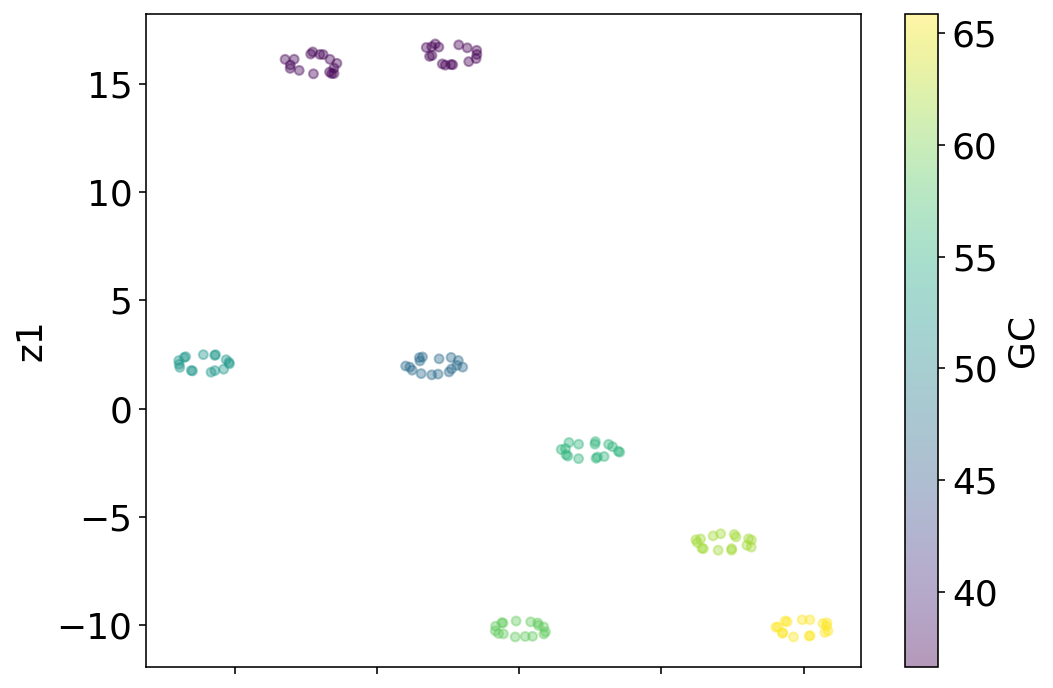

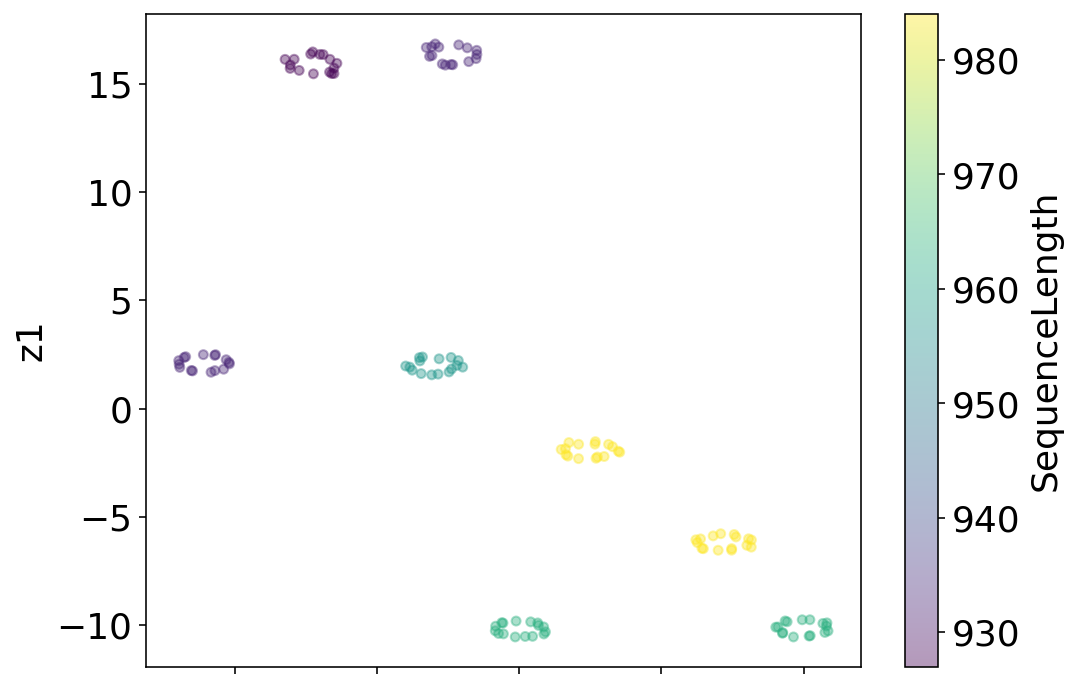

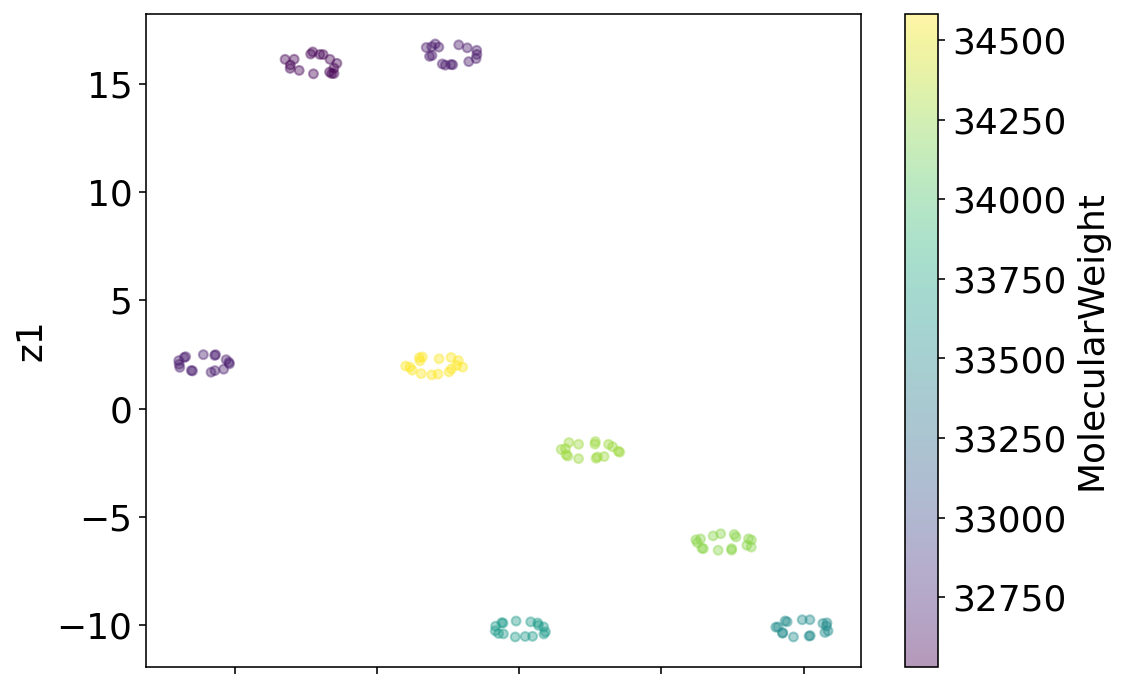

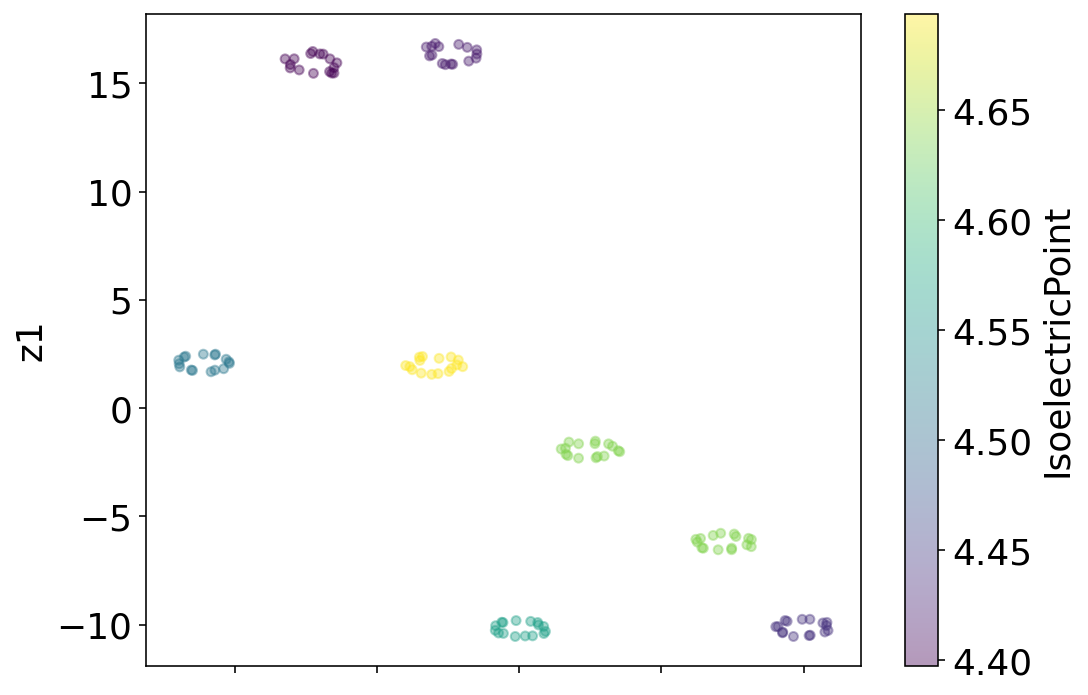

In [19]:
generated_tsne = run_tsne(generated_avg)
for key in generated_paint_df:
    print(key)
    gen_df = plot_tsne(generated_tsne, generated_paint_df[key], key, tsne_path, cmap="viridis")

In [20]:
# print(generated_tsne)
print(type(generated_tsne))
print(generated_tsne.shape)
print(gen_df)
print(type(gen_df))

<class 'numpy.ndarray'>
(128, 2)
           z0         z1  IsoelectricPoint
0   -3.214867  15.860788          4.397258
1    0.189410 -10.511563          4.565047
2   -4.152650   1.819189          4.515312
3    3.224928  -6.009643          4.638141
4    1.414467  -2.010913          4.638141
..        ...        ...               ...
123  2.484273  -6.055855          4.638141
124  0.659423  -2.129785          4.638141
125 -1.228074  16.703911          4.417549
126 -0.949303   1.832048          4.693900
127  3.701049 -10.369209          4.438978

[128 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>


## UMAP

In [21]:
def run_umap(data: np.ndarray):
    # to enable consistency of trained embeddings
    model = UMAP(random_state=10)
    data_proj = model.fit_transform(data)
    return data_proj

In [22]:
def plot_umap(data_proj: np.ndarray, paint: np.ndarray, paint_name: str, cmap: str = "plasma"):
    df = pd.DataFrame({"z0": data_proj[:, 0], "z1": data_proj[:, 1], paint_name: paint[:data_proj.shape[0]]})
    df.plot.scatter(x='z0', y='z1',c=paint_name, colormap=cmap, alpha=0.4)
    plt.show()
    return df

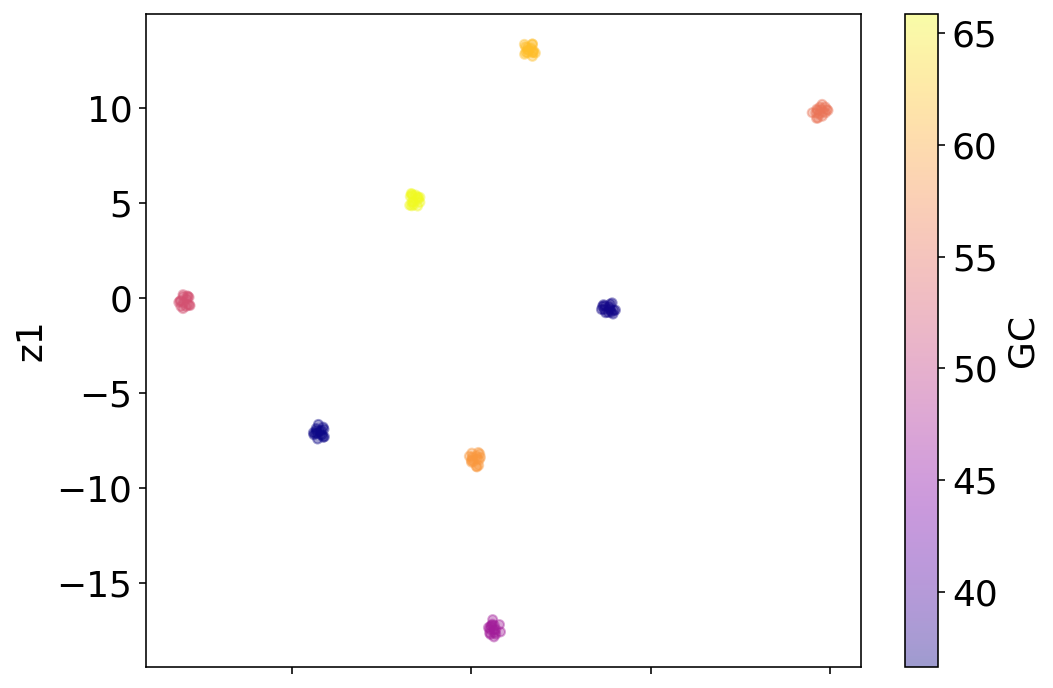

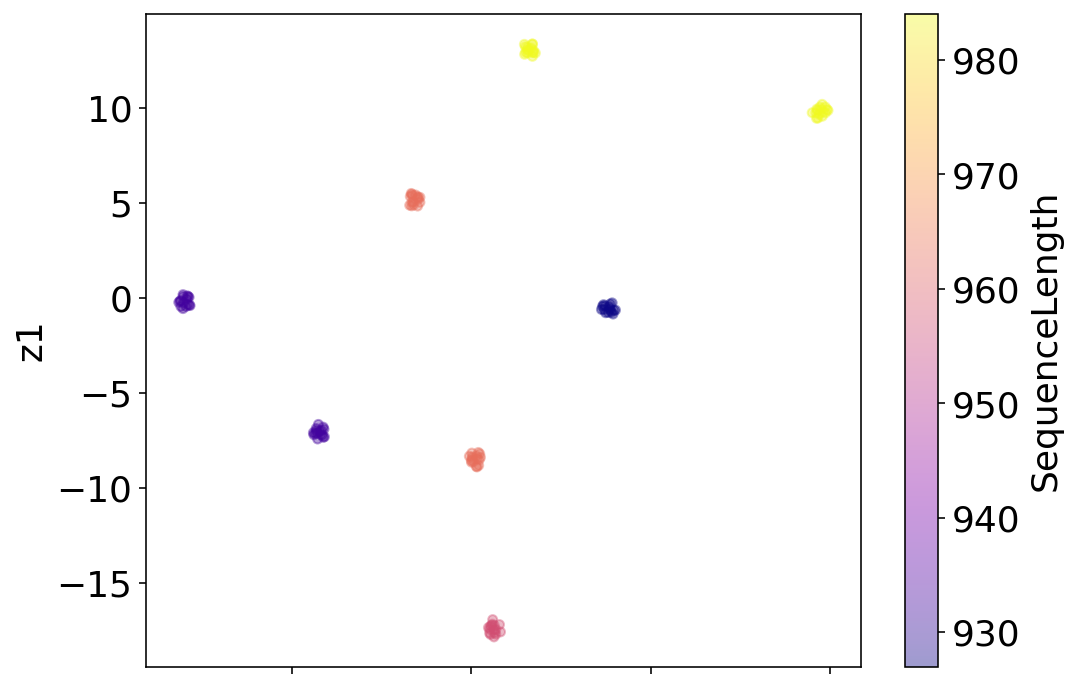

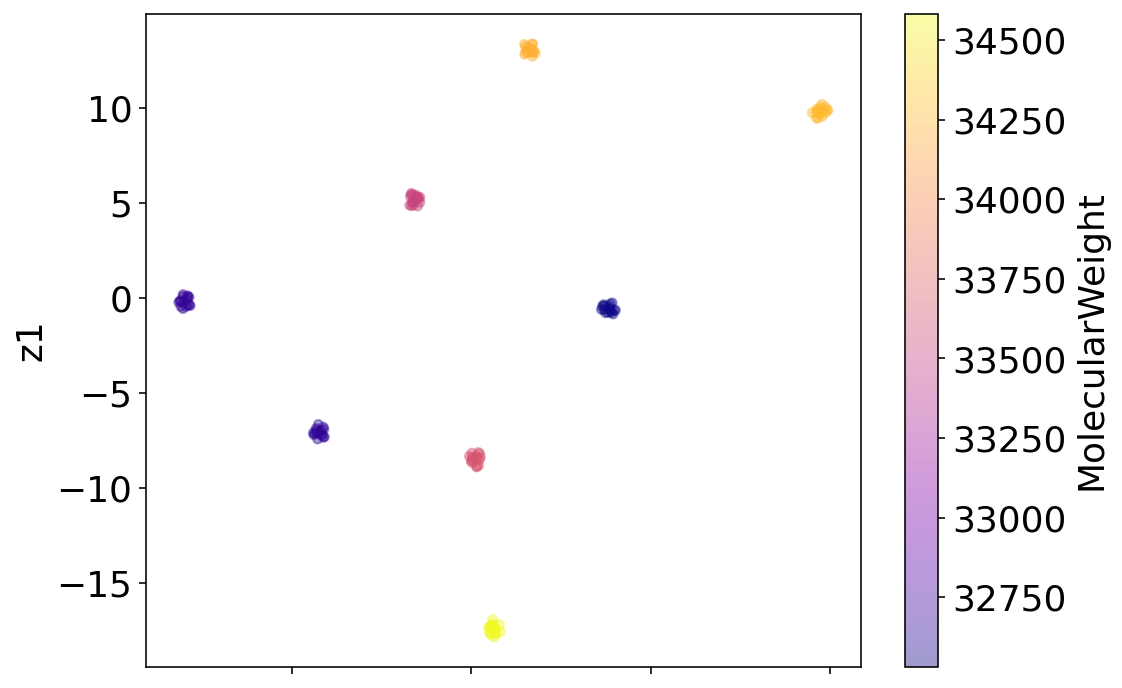

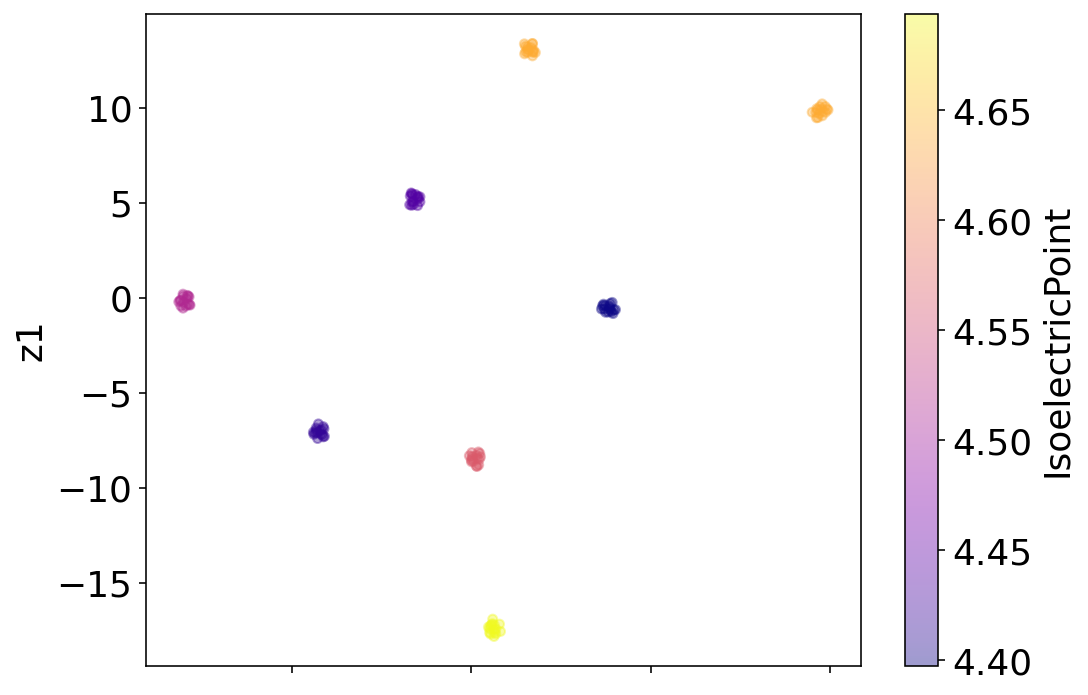

In [23]:
generated_umap = run_umap(generated_avg)
for key in generated_paint_df:
    gen_df = plot_umap(generated_umap, generated_paint_df[key], key, cmap="plasma")

In [24]:
gen_df

,z0,z1,IsoelectricPoint
0,7.389132,-0.594496,4.397258
1,0.465836,-8.195488,4.565047
2,-16.068207,-0.550386,4.515312
3,2.961643,12.836628,4.638141
4,19.223923,9.467081,4.638141
...,...,...,...
123,3.564610,12.906284,4.638141
124,19.724739,9.756105,4.638141
125,-8.569005,-7.415097,4.417549
126,1.065168,-17.706856,4.693900


# Alignment
## Calculate alignment scores

## Using PairwiseAligner

In [25]:
from Bio import Align
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

def compute_alignment_scores(kwargs: dict) -> np.ndarray:
    # Input arguments to parallel function    
    target_seq = kwargs.get("target_seq")
    seqs = kwargs.get("query_seqs")
    alignment_type = kwargs.get("alignment_type")
        
    aligner = Align.PairwiseAligner()
    aligner.mode = alignment_type # default is global, could also be local
    scores = np.array([aligner.align(target_seq, seq).score for seq in seqs])
    
    return scores


def alignment_scores_parallel(
    seqs1_rec: List[SeqRecord],
    seqs2_rec: List[SeqRecord],
    alignment_type: str = "global",
    num_workers: int = 1) -> np.ndarray:
    """Computes all pairwise alignments scores between sequences 
    in seqs1 and seqs2"""
    
    # save sequences as Seq objects rather than SeqRecord objects, since PairwiseAligner must work with Seq objects, not SeqRecord objects
    # seqs1 = list(Seq(rec.seq) for rec in seqs1_rec)
    # seqs2 = list(Seq(rec.seq) for rec in seqs2_rec)
    seqs1 = list(rec.seq for rec in seqs1_rec)
    seqs2 = list(rec.seq for rec in seqs2_rec)
    
    kwargs = [
        {
            "target_seq": seq,
            "query_seqs": seqs2,
            "alignment_type": alignment_type,
        }
        for seq in seqs1 
    ]
    
    scores_matrix = []
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        for scores in tqdm(executor.map(compute_alignment_scores, kwargs)):
            scores_matrix.append(scores)
    print("2")
    return np.array(scores_matrix)


## Set up scores df

In [26]:
from scipy.spatial import distance_matrix

def get_embed_dist_flatten(embed_avg: np.ndarray) -> np.ndarray:
    # get embedding distance
    embed_dist = distance_matrix(embed_avg, embed_avg)
    
    # get upper triangular matrix and flatten
    embed_dist_upper = np.triu(embed_dist).flatten()
    embed_dist_upper = embed_dist_upper[embed_dist_upper > 0]
    
    print(embed_dist_upper)
    print(type(embed_dist_upper))
    
    return embed_dist_upper

In [27]:
embed_dist_upper = get_embed_dist_flatten(generated_avg)

[0.08047912 0.05739055 0.08301563 ... 0.04761494 0.09489959 0.06971401]
<class 'numpy.ndarray'>


In [28]:
def get_scores_flatten(scores_matrix: np.ndarray) -> np.ndarray:
    # scores_matrix can be global_scores_matrix or local_scores_matrix
    # need to subtract from diagonal since alignment scores between the same seqeunce will be large positive values
    scores_upper = np.triu(scores_matrix - np.diag(np.diag(scores_matrix))).flatten()
    scores_upper = scores_upper[scores_upper > 0]
    return scores_upper

In [29]:
def get_scores_df(embed_avg: np.ndarray, scores_matrix: np.ndarray, alignment_type: str = "global") -> pd.DataFrame:
    # scores_matrix could be either global_scores_matrix or local_scores_matrix, specified by global_score = True or False
    
    if alignment_type == "global":
        align_key = "Global Alignment Score"
    elif alignment_type == "local":
        align_key = "Local Alignment Score"
    else:
        raise ValueError(f"Invalid alignment type: {alignment_type}")
    
    embed_dist_upper = get_embed_dist_flatten(embed_avg=embed_avg)
    scores_upper = get_scores_flatten(scores_matrix=scores_matrix)
    
    scores_df = pd.DataFrame({
    "Embedding L2 Distance": embed_dist_upper,
    align_key: scores_upper, 
})
    return scores_df

# TO DO: make another function that takes global_score

In [30]:
def get_avg_scores_df(scores_df: pd.DataFrame, alignment_type: str = "global") -> pd.DataFrame: 
    
    if alignment_type == "global":
        align_key = "Global Alignment Score"
    elif alignment_type == "local":
        align_key = "Local Alignment Score"
    else:
        raise ValueError(f"Invalid alignment type: {alignment_type}")
    
    unique_scores = scores_df[align_key].unique()
    
    # calculate embedding distance average
    avg_embed_dist = [np.mean(scores_df["Embedding L2 Distance"][scores_df[align_key] == score])
    for score in sorted(unique_scores)]
    
    # calculate embedding distance standard deviation
    stdev_embed_dist = [np.std(scores_df["Embedding L2 Distance"][scores_df[align_key] == score])
    for score in sorted(unique_scores)]
    
    # construct dataframe
    avg_scores_df = pd.DataFrame({
    "avg_embed_dist": avg_embed_dist,
    "stdev_embed_dist": stdev_embed_dist,
    align_key: sorted(unique_scores)
})
    return avg_scores_df

# Plot AlignScore_EmbedDist

In [31]:
def plot_AlignScore_EmbedDist(avg_scores_df: pd.DataFrame, save_path: Path, alignment_type: str = "global") -> str:
    if alignment_type == "global":
        align_key = "Global Alignment Score"
    elif alignment_type == "local":
        align_key = "Local Alignment Score"
    else:
        raise ValueError(f"Invalid alignment type: {alignment_type}")
    
    lower_bound = avg_scores_df["avg_embed_dist"] - avg_scores_df["stdev_embed_dist"]
    upper_bound = avg_scores_df["avg_embed_dist"] + avg_scores_df["stdev_embed_dist"]
    
    plt.plot(avg_scores_df[align_key], avg_scores_df["avg_embed_dist"], linewidth=3, label="average embedding distance")
    plt.fill_between(avg_scores_df[align_key], lower_bound, upper_bound, alpha=0.3, label="stdev embedding distance")
    plt.ylabel("L2 Embedding Distance", fontsize=14)
    plt.xlabel(align_key, fontsize=14)
    plt.title(align_key + " vs. L2 Embedding Distance")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    
    if save_path.is_dir():
        plt.savefig(save_path / ("AlignScore_EmbedDist.png"), dpi=300)
    else:
        raise ValueError(f"{save_path} is not a directory!")
    
    return f"Alignment Score vs. Embedding Distance plot has been saved to {save_path}."

### Test if the above code for alignment plotting works

In [32]:
p = Path("/homes/mzvyagin/MDH/gene_transformer/gene_transformer/data/full_mdh_fasta")
test_embed = np.load("/homes/mzvyagin/MDH/perlmutter_data/inference-test-embeddings.npy")
test_avg = test_embed.mean(axis=1)
test_seqs = list(SeqIO.parse(p / "test.fasta", "fasta"))
test_seqs = test_seqs[:len(test_embed)]
test_protein_seqs = [s.translate(to_stop=True) for s in test_seqs]

/homes/lind/.conda/envs/mdhpipeline/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [33]:
# generated_align_scores_test = alignment_scores_parallel(seqs1_rec = generated_protein_seqs, 
#                                                         seqs2_rec = generated_protein_seqs, 
#                                                         alignment_type = "global", 
#                                                         num_workers = 70)

In [34]:
test_align_scores_test = alignment_scores_parallel(seqs1_rec = test_protein_seqs, 
                                                        seqs2_rec = test_protein_seqs, 
                                                        alignment_type = "global", 
                                                        num_workers = 70)

3656it [04:00, 15.20it/s]


2


In [35]:
# scores_df = get_scores_df(embed_avg=generated_avg, 
#                           scores_matrix=generated_align_scores_test, 
#                           alignment_type="global")

In [ ]:
scores_df = get_scores_df(embed_avg=test_avg, 
                          scores_matrix=test_align_scores_test, 
                          alignment_type="global")

In [ ]:
scores_df

In [ ]:
avg_scores_df = get_avg_scores_df(scores_df=scores_df, alignment_type="global")

In [ ]:
avg_scores_df

In [ ]:
save_path = Path("/homes/lind/MDH-pipeline/visualize/")
plot_AlignScore_EmbedDist(avg_scores_df=avg_scores_df, save_path=save_path, alignment_type="global")

In [ ]:
scores_df[::100].plot.scatter(y="Embedding L2 Distance", x="Global Alignment Score")